In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __init__ import *

utils.rng.set_seed()
device = utils.gpu.set_devices(3)

In [3]:
experiment_name = 'pie_dense_superres_patch'
serialized_path = f'../serialized/experiments/{experiment_name}/'
nets = {'PIE': None, 'AE': None}
for m in nets:
    with open(f'{serialized_path}{m}.pt', 'rb') as outfile:
        nets[m] = torch.load(outfile)

In [4]:
tf = transforms.Compose([
    transforms.CenterCrop((384, 384)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

# Import data
train = datasets.get_coco(transform=tf)
test = datasets.get_coco(transform=tf, train=False)

In [5]:
split1 = modules.AdjointSequential(
    modules.AdjointPatchSplitter((24,24), (16,16)),
    modules.AdjointFlatten(-2, -1, (24,24))
)

split2 = modules.AdjointSequential(
    modules.AdjointUnflatten(-2, -1, (6, 6)),
    modules.AdjointPatchUnsplitter((6,6), (16,16)),
)

splitsmall = modules.AdjointSequential(
    modules.AdjointPatchSplitter((6,6), (16,16)),
    modules.AdjointFlatten(-2, -1, (6,6))
)

reshape = nn.AvgPool2d(4)


In [6]:
example = 6888

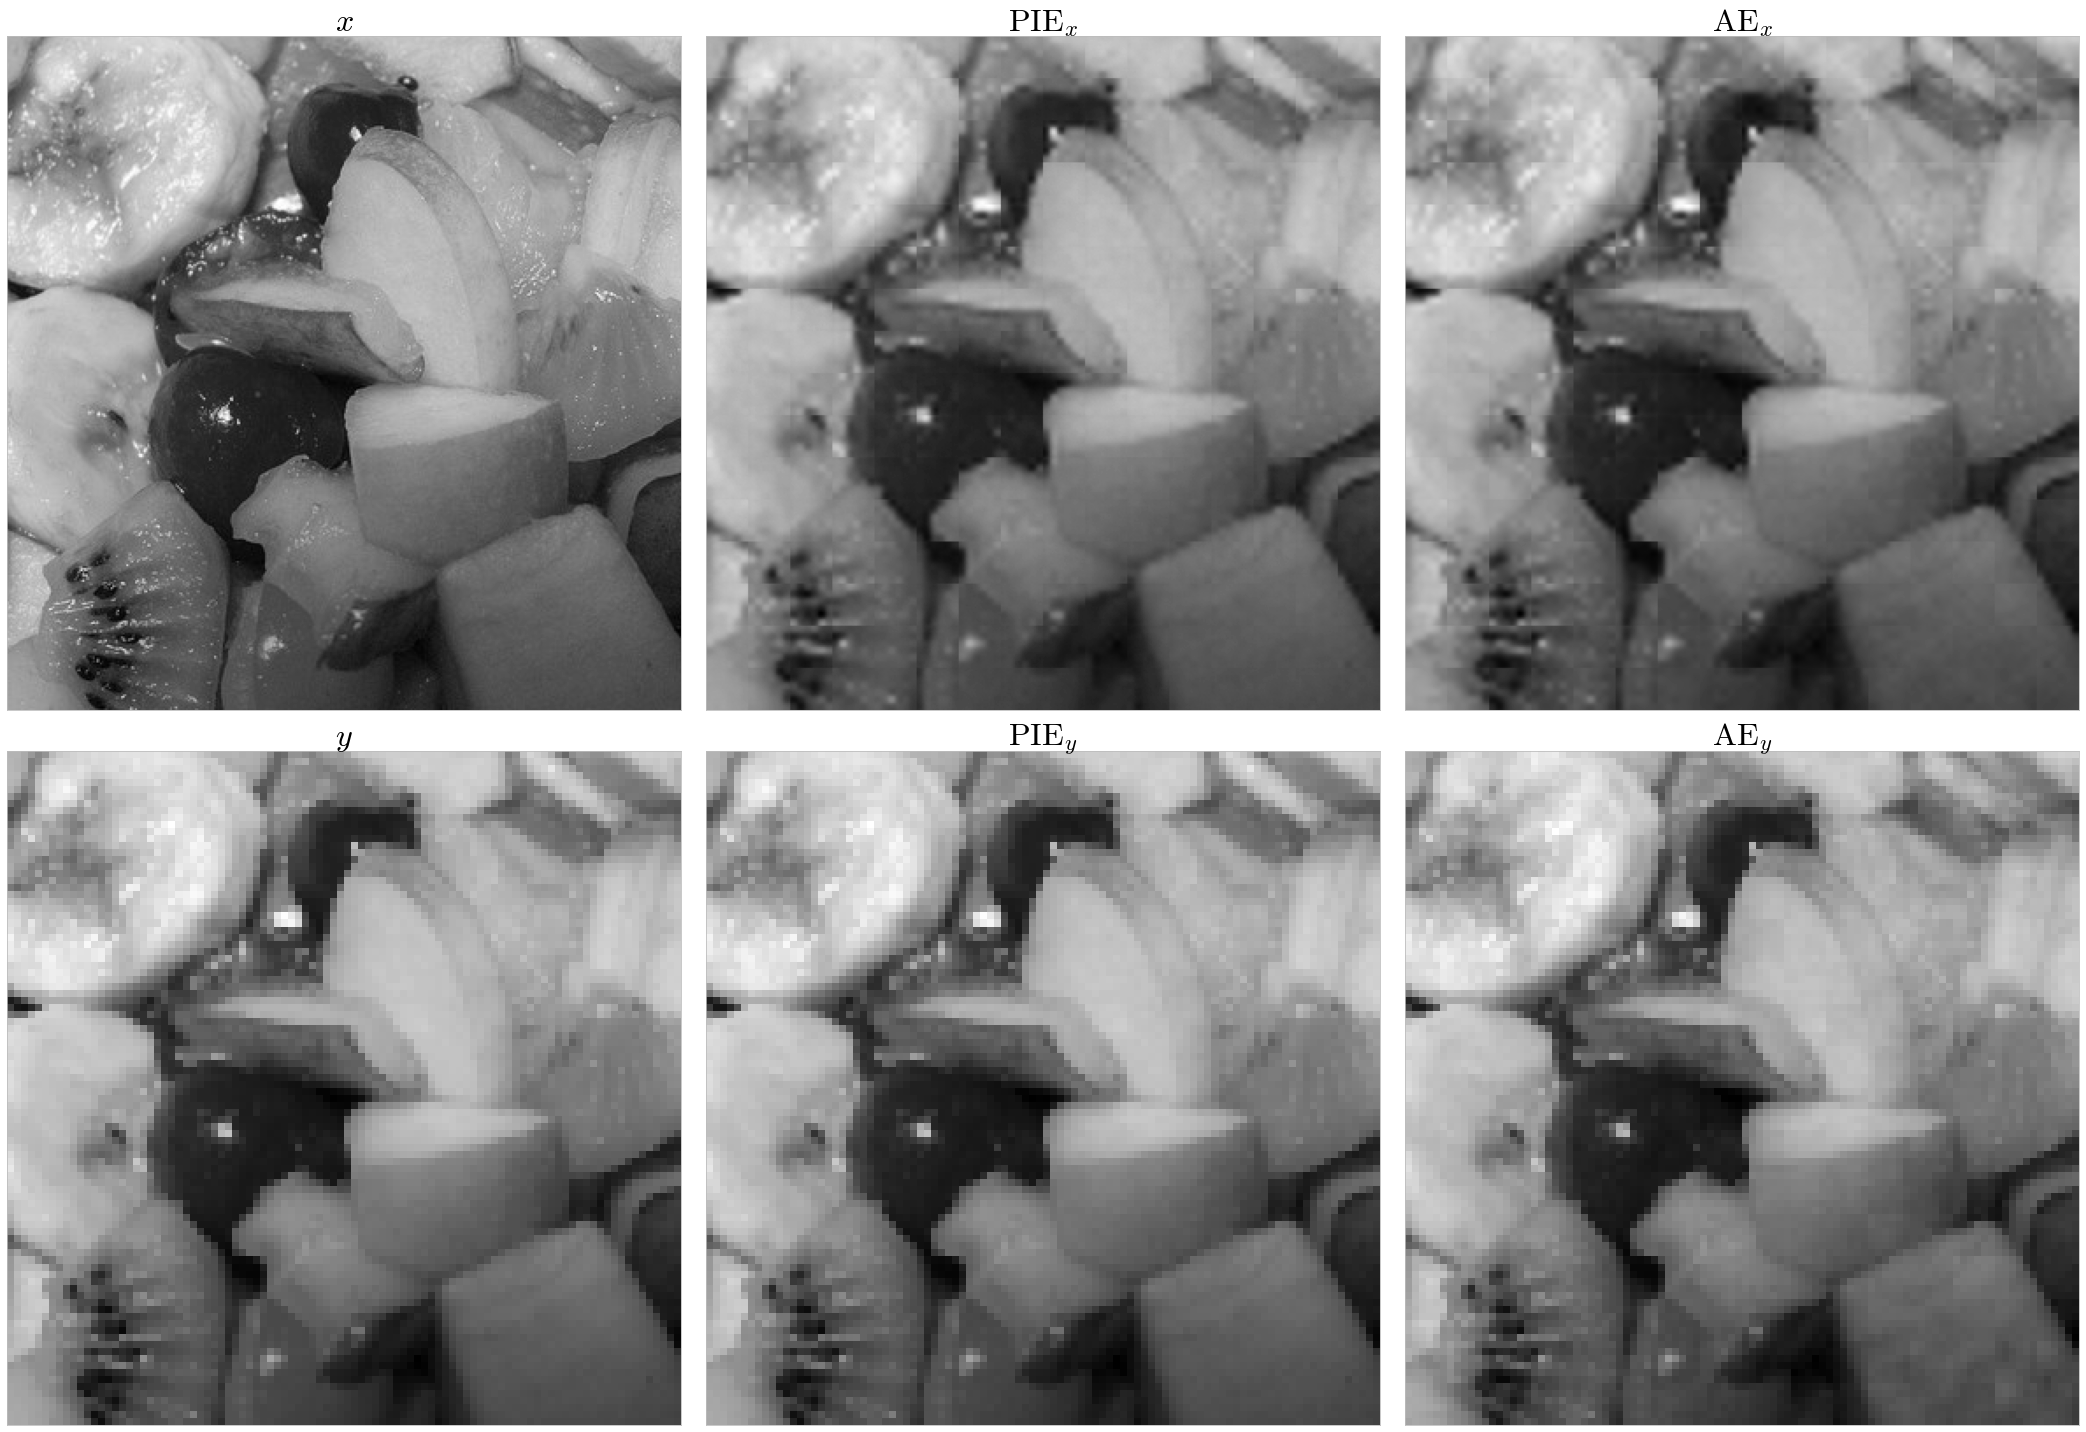

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(30,20))

ax[0,0].imshow(train[example][0], cmap='gray')
ax[0,0].set_title('$x$', fontsize=32)
ax[1,0].imshow(reshape(train[example])[0], cmap='gray')
ax[1,0].set_title('$y$', fontsize=32)


for i, cur in enumerate(nets):
    with torch.no_grad():
        yh = nets[cur](split1(train[example]))
        xh = nets[cur].T(splitsmall(reshape(train[example])))

    ax[0,i+1].imshow(
        split1.T(xh).cpu()[0],
        cmap='gray'
    )
    ax[0,i+1].set_title(f'$\mathrm{{{cur}}}_x$', fontsize=32)
    
    ax[1,i+1].imshow(
        splitsmall.T(yh).cpu()[0],
        cmap='gray'
    )
    ax[1,i+1].set_title(f'$\mathrm{{{cur}}}_y$', fontsize=32)
    
for a in ax.flatten():
    a.grid(False)
    a.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
    
plt.savefig(f'../figures/results/{experiment_name}_fruit.pdf')

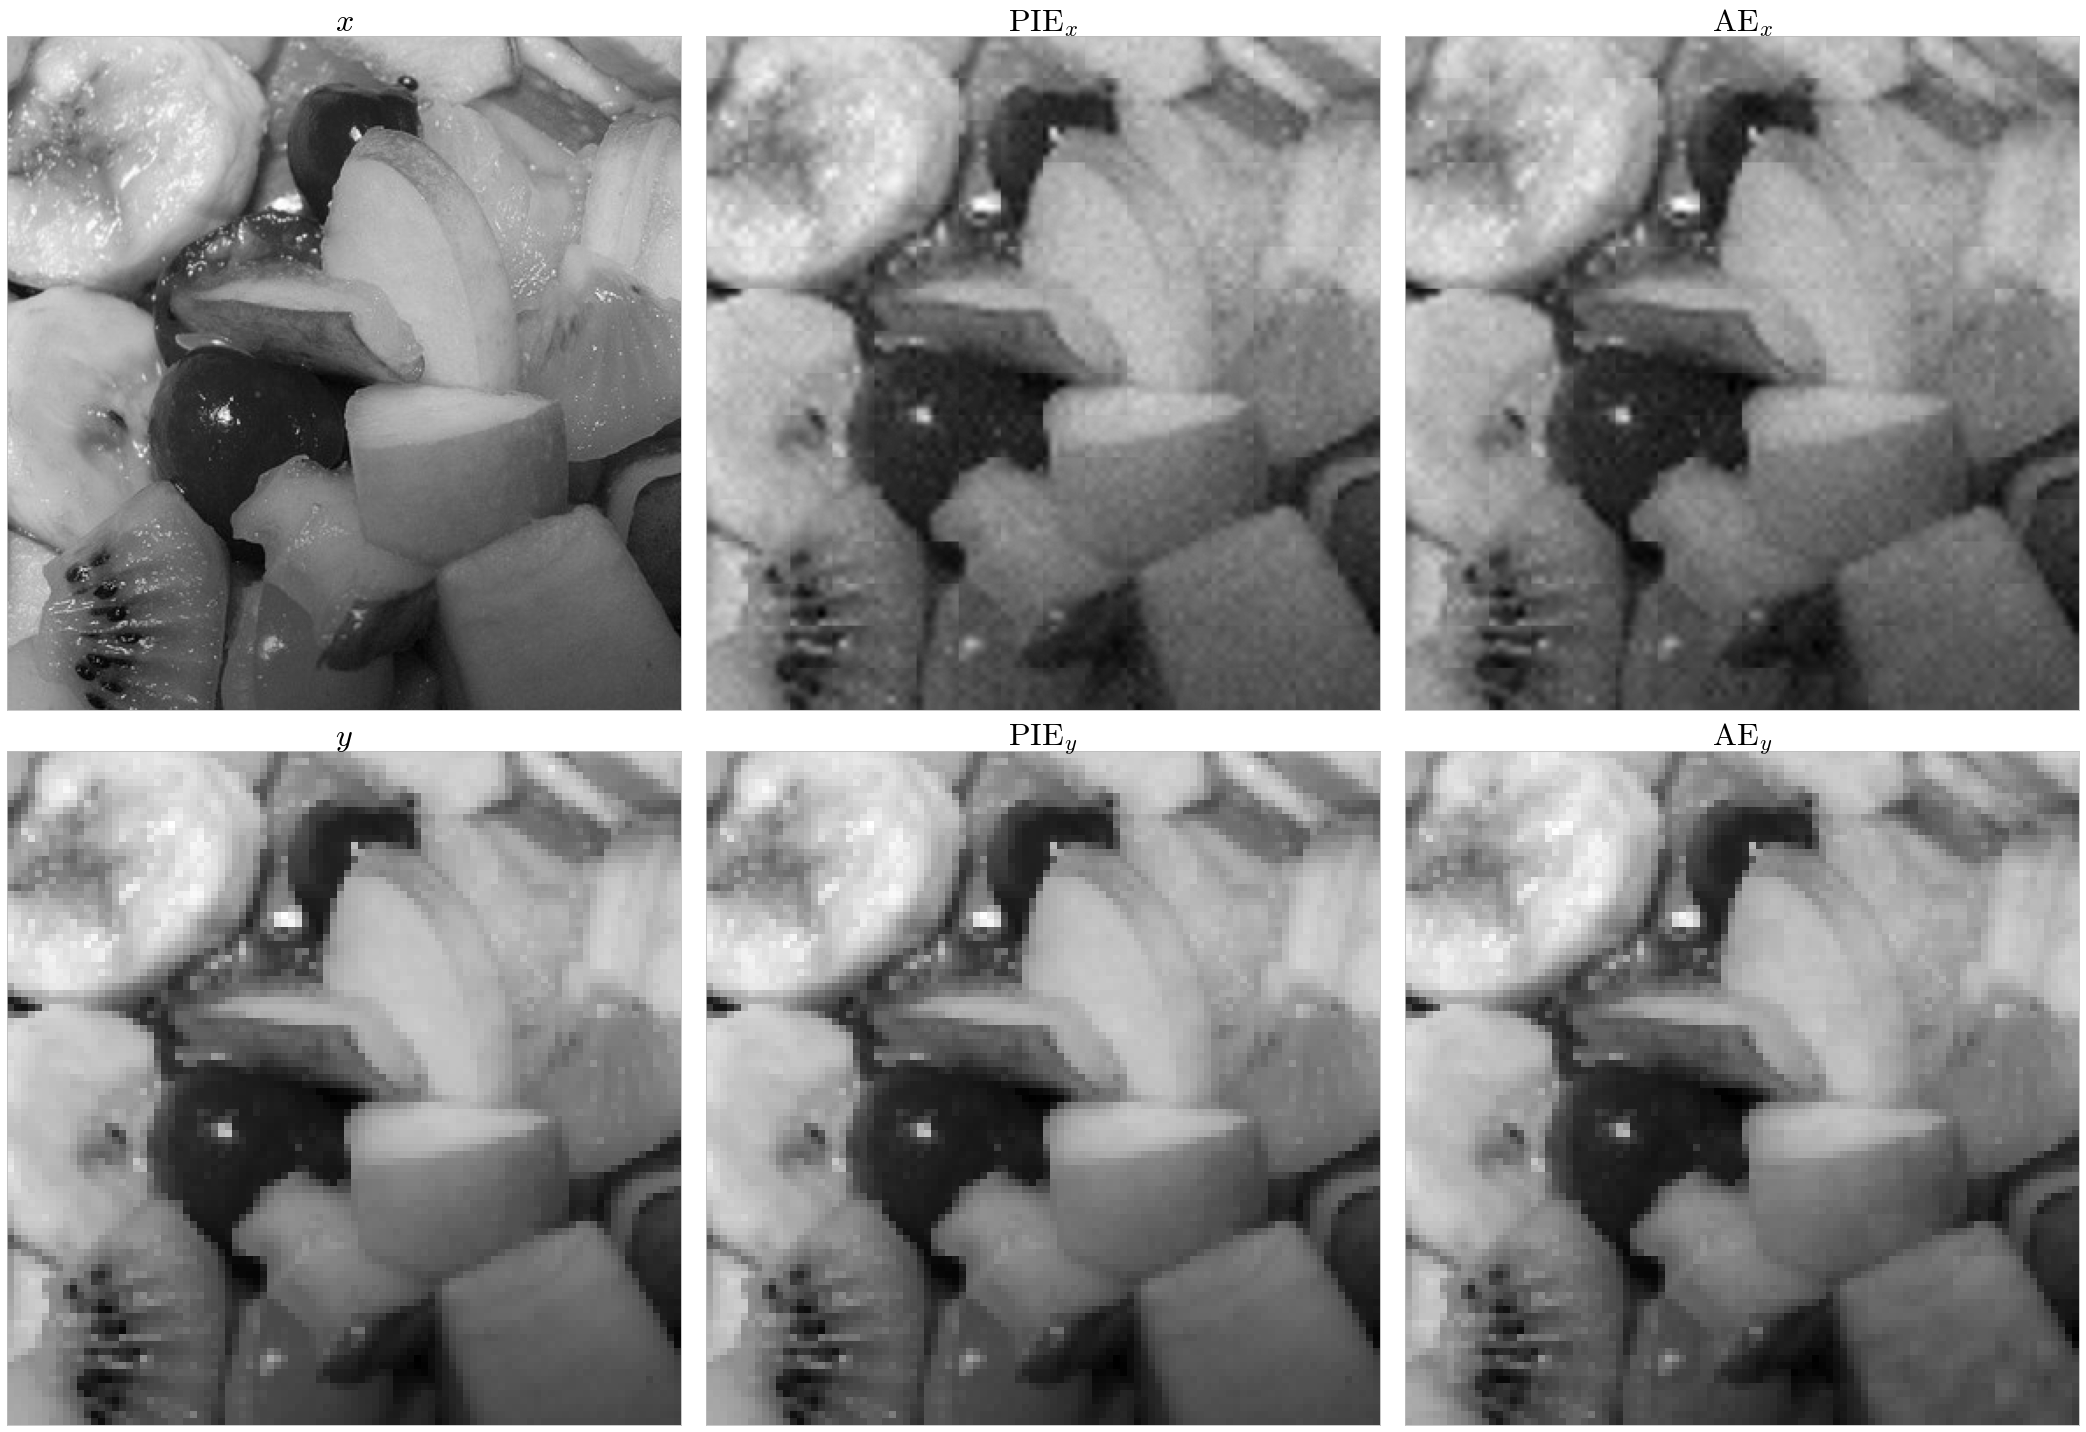

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(30,20))

ax[0,0].imshow(train[example][0], cmap='gray')
ax[0,0].set_title('$x$', fontsize=32)
ax[1,0].imshow(reshape(train[example])[0], cmap='gray')
ax[1,0].set_title('$y$', fontsize=32)


for i, cur in enumerate(nets):
    with torch.no_grad():
        yh = nets[cur](split1(train[example]))
        noise = torch.randn(1, 96, 96) * 0.015
        xh = nets[cur].T(splitsmall(reshape(train[example]) + noise))

    ax[0,i+1].imshow(
        split1.T(xh).cpu()[0],
        cmap='gray'
    )
    ax[0,i+1].set_title(f'$\mathrm{{{cur}}}_x$', fontsize=32)
    
    ax[1,i+1].imshow(
        splitsmall.T(yh).cpu()[0],
        cmap='gray'
    )
    ax[1,i+1].set_title(f'$\mathrm{{{cur}}}_y$', fontsize=32)
    
for a in ax.flatten():
    a.grid(False)
    a.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
    
plt.savefig(f'../figures/results/{experiment_name}_fruit.pdf')

In [9]:
# Compute test tensor

test_tensor = []
for i in tqdm(range(len(test))):
    test_tensor.append(test[i])
    
test_tensor = split1(torch.cat(test_tensor))

  0%|          | 0/4002 [00:00<?, ?it/s]

In [10]:
# Calculate relative error on test data

print(f"Relative Error:")
for k, model in nets.items():
    with torch.no_grad():
        xth = model.T(splitsmall(reshape(split1.T(test_tensor))))
    print(
        f"{k:6}: " + 
        f"RE {utils.metrics.relative_error(split1.T(xth).flatten(-2, -1), split1.T(test_tensor).flatten(-2, -1), reduction='mean'):4E} " +
        f"MSE {F.mse_loss(split1.T(xth).flatten(-2, -1), split1.T(test_tensor).flatten(-2, -1), reduction='mean'):4E} "
    )

Relative Error:
PIE   : RE 1.395652E-01 MSE 5.348960E-03 
AE    : RE 1.442600E-01 MSE 5.613331E-03 


In [11]:
del xth
import gc
gc.collect();

In [12]:
# Calculate relative error on test data

print(f"Relative Error:")
for k, model in nets.items():
    with torch.no_grad():
        yth = model(test_tensor)
    print(
        f"{k:6}: " + 
        f"RE {utils.metrics.relative_error(yth.flatten(-2, -1), splitsmall(reshape(split1.T(test_tensor))).flatten(-2, -1), reduction='mean'):4E} " +
        f"MSE {F.mse_loss(yth.flatten(-2, -1), splitsmall(reshape(split1.T(test_tensor))).flatten(-2, -1), reduction='mean'):4E} "
    )

Relative Error:
PIE   : RE 1.098013E-02 MSE 3.233189E-05 
AE    : RE 3.768489E-02 MSE 3.667601E-04 


In [13]:
del yth
gc.collect();

In [14]:
# PIE
(1.098013E-02 + 1.395652E-01)/2

0.075272665

In [15]:
# AE
(1.442600E-01 + 3.768489E-02)/2

0.090972445

In [16]:
# Calculate PSNR and SSIM on test data
print(f"Image Reconstruction Metrics:")
for k, model in nets.items():
    with torch.no_grad():
        XH = model.T(splitsmall(reshape(split1.T(test_tensor))))
        dothings = lambda x: split1.T(x).flatten(-2, -1)
        psnr = utils.metrics.psnr(dothings(test_tensor), dothings(XH))
        ssim = utils.metrics.ssim(
            split1.T(test_tensor)[:,None,...], 
            split1.T(XH)[:,None,...]
        )
    print(
        f"{k:6}: " + 
        f"PSNR {psnr:4E} " +
        f"SSIM {ssim:4E} "
    )

# Clear memory
del XH
gc.collect();

Image Reconstruction Metrics:
PIE   : PSNR 2.271731E+01 SSIM 6.762649E-01 
AE    : PSNR 2.250779E+01 SSIM 6.658737E-01 


In [17]:
# Calculate PSNR and SSIM on test data
print(f"Image Reconstruction Metrics:")
for k, model in nets.items():
    with torch.no_grad():
        YH = model(test_tensor)
        dothings = lambda x: splitsmall(reshape(split1.T(x)))
        psnr = utils.metrics.psnr(dothings(test_tensor).flatten(-2, -1), YH.flatten(-2, -1))
        ssim = utils.metrics.ssim(
            dothings(test_tensor)[:,None,...], 
            YH[:,None,...]
        )
    print(
        f"{k:6}: " + 
        f"PSNR {psnr:4E} " +
        f"SSIM {ssim:4E} "
    )

# Clear memory
del YH
gc.collect();

Image Reconstruction Metrics:
PIE   : PSNR 4.490369E+01 SSIM 9.980380E-01 
AE    : PSNR 3.435618E+01 SSIM 9.832099E-01 


In [17]:
# PIE
(2.271731E+01+4.490369E+01)/2

33.8105

In [18]:
# AE
(2.250779E+01+3.435618E+01)/2

28.431985

In [19]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

utils.rng.set_seed(42)

# Estimate Condition Number using Adverserial Perturbation
rs = {}
opts_p = {}
epochs = 3
loss_trace_p = {}
for k in nets.keys():
    loss_trace_p[k] = {'l': [], 'lphi': []}
    rs[k] = nn.Parameter(torch.randn(256, 576).to(device))
    _zs = torch.sum(rs[k] == 0)
    while _zs > 0:
        rs[k][rs[k] == 0] = nn.Parameter(torch.random.randn(_zs))
        _zs = torch.sum(rs[k] == 0)
    nets[k].eval()
    opts_p[k] = torch.optim.Adam([rs[k]])

In [20]:
# Define Perturbation Objective
def perturbation_objective(xe, xh, ye, yh):
    losses = {}
    
    lphix = -F.mse_loss(xe, xh)
    lphiy = -F.mse_loss(ye, yh)
    losses['lphix'] = lphix
    losses['lphiy'] = lphiy

    return sum(losses.values()), losses

In [21]:
loader = torch.utils.data.DataLoader(
    train, batch_size=32, shuffle=True, pin_memory=True
)

In [22]:
# Set examples for training, testing and visualization
sample_indices_small = np.array([0, 3, 42, 85, 666, 1001, 6969, 31415])

# Convert sample indices to tensors
xims = torch.cat([train[k] for k in sample_indices_small])
ys = splitsmall(reshape(xims)).to(device)
xs = split1(xims).to(device)


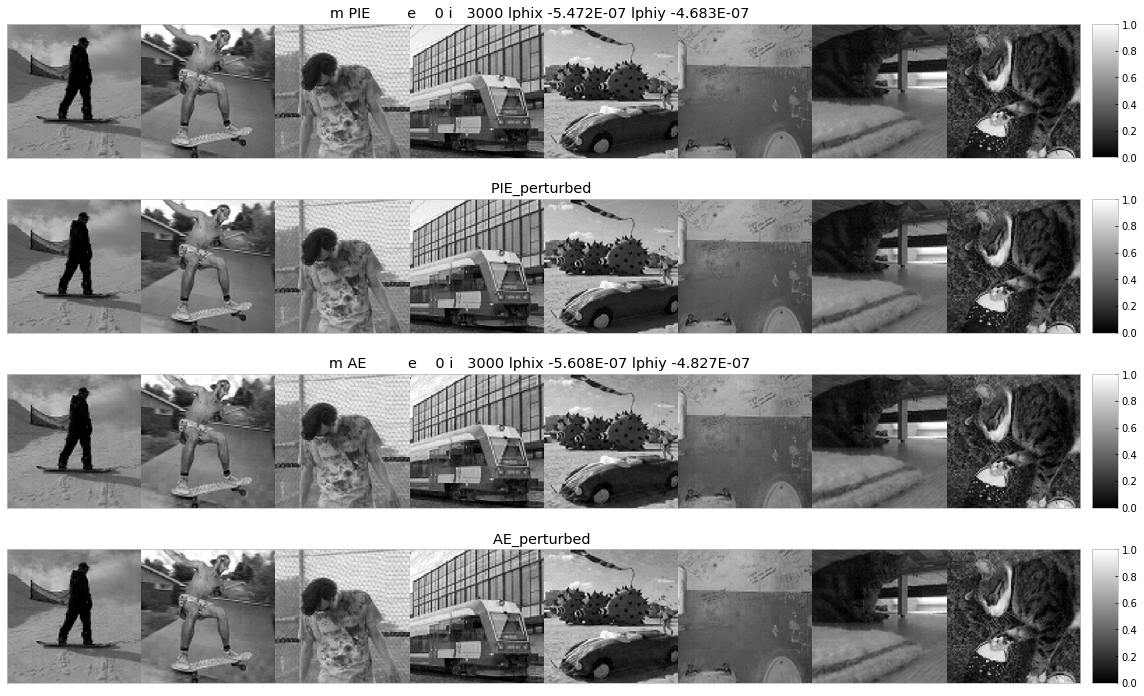

In [23]:
# Training loop

for e in range(1):
    i = 0
    for x in loader:
        y = splitsmall(reshape(x.to(device))).detach()
        x = split1(x.to(device))
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts_p[cur].zero_grad()
            r = utils.projection.project_into_ball(rs[cur].flatten(-2, -1), 1, 2).unflatten(-1, (256, 576))

            yh = nets[cur](x)
            ye = nets[cur](x + r)
            xh = nets[cur].T(yh)
            xe = nets[cur].T(ye)

            # Calculate loss
            loss, ldicts[cur] = perturbation_objective(xe, xh, yh, ye)

            loss.backward()
            opts_p[cur].step()
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace_p[cur]:
                    loss_trace_p[cur][k] = []

                loss_trace_p[cur][k].append(v)


        # Plot and Report
        if i % 15 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    per = f'{cur}_perturbed'
                    r = utils.projection.project_into_ball(rs[cur].flatten(-2, -1), 1, 2).unflatten(-1, (256, 576))

                    xhs[cur] = split1.T(nets[cur].T(nets[cur](xs))).cpu()
                    xhs[per] = split1.T(nets[cur].T(nets[cur](xs + r))).cpu()
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, save=False, cmap='gray')            
        i += 1

In [24]:
for cur, model in nets.items():
    nets[cur] = model.to('cpu')

print(f"Relative Cond:")

for k, model in nets.items():
    with torch.no_grad():
        r = utils.projection.project_into_ball(rs[k].flatten(-2, -1).cpu(), 1, 2).unflatten(-1, (256, 576))
        XE = model.T(model(test_tensor + r))
        XH = model.T(model(test_tensor))

    rerr_psi = utils.metrics.relative_error(XH.flatten(-2,-1), XE.flatten(-2,-1), reduction='mean')
    rerr_x = utils.metrics.relative_error(test_tensor.flatten(-2,-1), (test_tensor + r).flatten(-2,-1), reduction='mean')
    cond_no = utils.metrics.relative_cond_no(XH.flatten(-2,-1), XE.flatten(-2,-1), test_tensor.flatten(-2,-1), r.flatten(-2,-1), reduction='mean')
    
    print(f"{k:6}: {rerr_psi.item():2.6f} {rerr_x.item():2.6f} {cond_no.item():2.6f}")

Relative Cond:
PIE   : 0.001545 0.005357 0.051164
AE    : 0.001561 0.005357 0.051675


In [25]:
# Save state dict

serialized_path = f'../serialized/experiments/{experiment_name}/'
if not os.path.isdir(serialized_path):
    os.mkdir(serialized_path)

for k in nets:
    torch.save(nets[k].state_dict(), serialized_path + k + '.ptsd')

In [29]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

utils.rng.set_seed(42)

# Estimate Condition Number using Adverserial Perturbation
rs = {}
opts_p = {}
epochs = 3
loss_trace_p = {}
for k in nets.keys():
    loss_trace_p[k] = {'l': [], 'lphi': []}
    rs[k] = nn.Parameter(torch.randn(256, 36).to(device))
    _zs = torch.sum(rs[k] == 0)
    while _zs > 0:
        rs[k][rs[k] == 0] = nn.Parameter(torch.random.randn(_zs))
        _zs = torch.sum(rs[k] == 0)
    nets[k].eval()
    opts_p[k] = torch.optim.Adam([rs[k]])

In [30]:
# Define Perturbation Objective
def perturbation_objective(xe, xh):
    losses = {}
    
    lphix = -F.mse_loss(xe, xh)
    losses['lphix'] = lphix

    return sum(losses.values()), losses

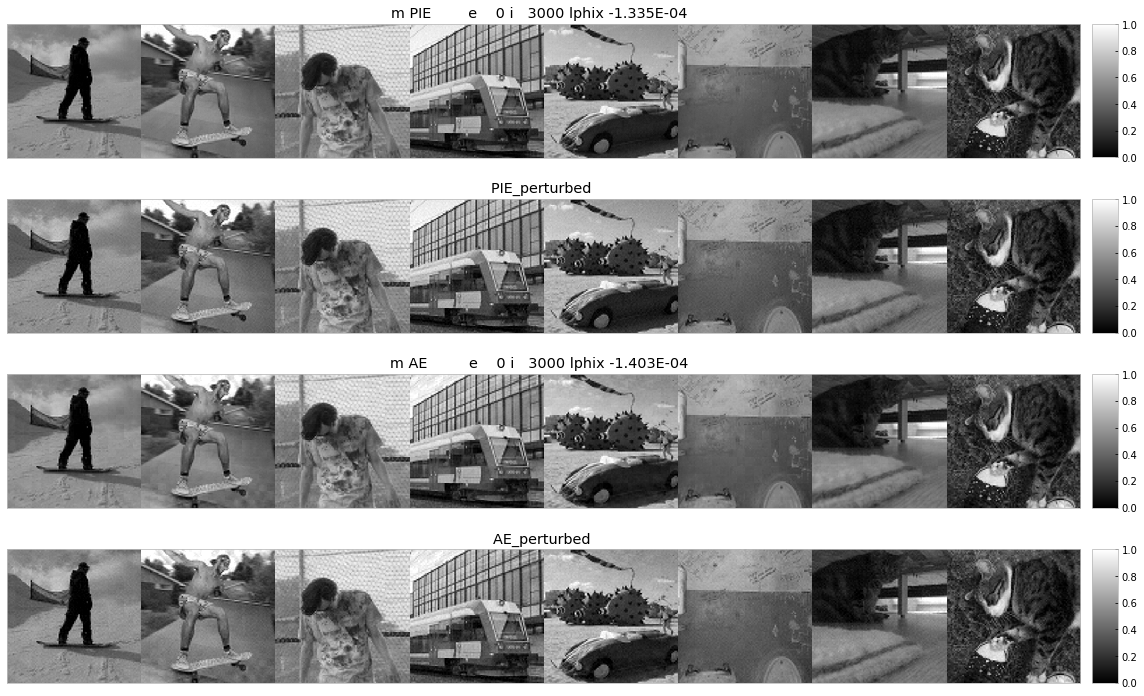

In [31]:
# Training loop

for e in range(1):
    i = 0
    for x in loader:
        y = splitsmall(reshape(x.to(device))).detach()
        x = split1(x.to(device))
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts_p[cur].zero_grad()
            r = utils.projection.project_into_ball(rs[cur].flatten(-2, -1), 1, 2).unflatten(-1, (256, 36))

            xh = nets[cur].T(y)
            xe = nets[cur].T(y + r)

            # Calculate loss
            loss, ldicts[cur] = perturbation_objective(xe, xh)

            loss.backward()
            opts_p[cur].step()
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace_p[cur]:
                    loss_trace_p[cur][k] = []

                loss_trace_p[cur][k].append(v)


        # Plot and Report
        if i % 15 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    per = f'{cur}_perturbed'
                    r = utils.projection.project_into_ball(rs[cur].flatten(-2, -1), 1, 2).unflatten(-1, (256, 36))

                    xhs[cur] = split1.T(nets[cur].T(nets[cur](xs))).cpu()
                    xhs[per] = split1.T(nets[cur].T(nets[cur](xs) + r)).cpu()
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, save=False, cmap='gray')            
        i += 1

In [37]:
for cur, model in nets.items():
    nets[cur] = model.to('cpu')

print(f"Relative Cond:")
yt = splitsmall(reshape(split1.T(test_tensor))).detach()
for k, model in nets.items():
    with torch.no_grad():
        r = utils.projection.project_into_ball(rs[cur].flatten(-2, -1), 1, 2).unflatten(-1, (256, 36)).cpu()
        XH = nets[cur].T(yt)
        XE = nets[cur].T(yt + r)

    cond_no = utils.metrics.relative_cond_no(XH.flatten(-2,-1), XE.flatten(-2,-1), yt.flatten(-2,-1), r.flatten(-2,-1), reduction='mean')
    
    print(f"{k:6}: {cond_no.item():2.6f}")

Relative Cond:
PIE   : 0.810018
AE    : 0.810018
